In [1]:
# Updated March 22, 2025

# 1. Import Libraries

In [1]:
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#  1. Import libraries
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# 2. Data loading

In [3]:
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#  2. Data loading
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
file_path = os.path.join("data", "diabetes_prediction_dataset.csv")
df = pd.read_csv(file_path)

print(f"Dataset Shape: {df.shape}")
print(f"Missing Values:\n{df.isnull().sum()}")
print(f"Duplicate Rows: {df.duplicated().sum()}")


df.head()

Dataset Shape: (100000, 9)
Missing Values:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
Duplicate Rows: 3854


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# 3. Data cleaning & Encoding

**check for duplicates**

In [4]:
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#  3. Data Cleaning
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
duplicate_rows = df[df.duplicated()]
display(duplicate_rows.head(10))
df = df.drop_duplicates().reset_index(drop=True)
print(f"Dataset Shape After Removing Duplicates: {df.shape}")


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
2756,Male,80.0,0,0,No Info,27.32,6.6,159,0
3272,Female,80.0,0,0,No Info,27.32,3.5,80,0
3418,Female,19.0,0,0,No Info,27.32,6.5,100,0
3939,Female,78.0,1,0,former,27.32,3.5,130,0
3960,Male,47.0,0,0,No Info,27.32,6.0,200,0
4106,Female,51.0,0,0,No Info,27.32,6.6,200,0
4128,Female,80.0,0,0,never,27.32,5.7,85,0
4224,Male,80.0,1,0,former,27.32,6.2,130,0
4263,Male,80.0,0,0,No Info,27.32,6.0,100,0
4486,Male,50.0,0,0,No Info,27.32,4.8,155,0


Dataset Shape After Removing Duplicates: (96146, 9)


Checking missing value

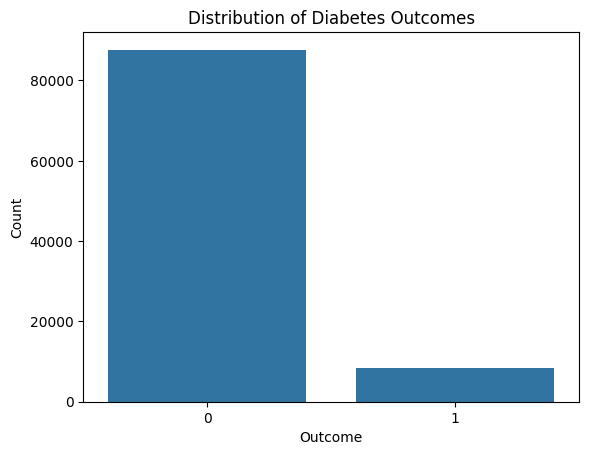

In [5]:
# print(df.isnull().sum())
sns.countplot(x=df['diabetes'], data=df)
plt.title('Distribution of Diabetes Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

Label Encoder

**Review the categorical variables**
 - **if needed, we will use label encoding**

In [6]:
# Check unique values for 'gender'
print("Unique values in 'gender':", df['gender'].unique())

# Check unique values for 'smoking_history'
print("Unique values in 'smoking_history':", df['smoking_history'].unique())


Unique values in 'gender': ['Female' 'Male' 'Other']
Unique values in 'smoking_history': ['never' 'No Info' 'current' 'former' 'ever' 'not current']


**Since Gender has 3 values, we can keep the Label encoding as-is**
**However, smoking_history has 6 values, so we will use one-hot encoding**


In [7]:
# Encode 'gender'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])


**Encoding smoking_history for RandomForest**

In [8]:
# Encode 'smoking_history' using LabelEncoder
# df_original = pd.read_csv(file_path)
# Restore 'smoking_history' if missing
if 'smoking_history' not in df.columns:
    df_original = pd.read_csv(file_path)  # Load fresh dataset
    df['smoking_history'] = df_original['smoking_history']

le_smoking = LabelEncoder()
df['smoking_history_encoded'] = le_smoking.fit_transform(df['smoking_history'])

# Use encoded version
selected_features_random_forest = ["HbA1c_level", "blood_glucose_level", "bmi", "age", 
                                   "hypertension", "heart_disease", "smoking_history_encoded"]

# Create a separate DataFrame for Random Forest modeling
df_random_forest = df[selected_features_random_forest + ["diabetes"]]

**Encoding smoking_history for all models except RandomForest**

In [9]:
# Implementing Target Encoding for 'smoking_history'
# Assuming the dataset contains a binary target variable 'diabetes'

# Calculate mean diabetes rate per smoking category (Target Encoding)
df['smoking_encoded'] = df.groupby('smoking_history')['diabetes'].transform('mean')

# Drop original smoking_history columns after target encoding
df.drop(columns=[col for col in df.columns if 'smoking_history' in col], inplace=True)

# Display updated column names after encoding
print("Updated Columns after Encoding:", df.columns)

# Display first few rows to verify encoding
display(df.head())

Updated Columns after Encoding: Index(['gender', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'smoking_encoded'],
      dtype='object')


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded
0,0,80.0,0,1,25.19,6.6,140,0,0.097011
1,0,54.0,0,0,27.32,6.6,80,0,0.043938
2,1,28.0,0,0,27.32,5.7,158,0,0.097011
3,0,36.0,0,0,23.45,5.0,155,0,0.103077
4,1,76.0,1,1,20.14,4.8,155,0,0.103077


**encoding smoking_history for ensemble method**

In [10]:
from sklearn.preprocessing import LabelEncoder

# Restore 'smoking_history' if missing
if 'smoking_history' not in df.columns:
    df_original = pd.read_csv(file_path)  # Load fresh dataset
    df['smoking_history'] = df_original['smoking_history']

# ======== ENCODING FOR RANDOM FOREST ========
le_smoking = LabelEncoder()
df['smoking_history_encoded'] = le_smoking.fit_transform(df['smoking_history'])

selected_features_random_forest = [
    "HbA1c_level", "blood_glucose_level", "bmi", "age",
    "hypertension", "heart_disease", "smoking_history_encoded"
]

# Create a separate DataFrame for Random Forest modeling
df_random_forest = df[selected_features_random_forest + ["diabetes"]]

# ======== ENCODING FOR ENSEMBLE METHOD (TARGET ENCODING) ========
# Calculate mean diabetes rate per smoking category (Target Encoding)
df['smoking_encoded_ensemble'] = df.groupby('smoking_history')['diabetes'].transform('mean')

# Drop original `smoking_history` column, but **preserve encoded versions** separately
df.drop(columns=['smoking_history'], inplace=True)

# Define selected features for Ensemble Model (use target encoding)
selected_features_ensemble = [
    "HbA1c_level", "blood_glucose_level", "bmi", "age",
    "hypertension", "heart_disease", "smoking_encoded_ensemble"
]

# Create a separate DataFrame for the Ensemble method
df_ensemble = df[selected_features_ensemble + ["diabetes"]]

# ======== DISPLAY UPDATED COLUMNS ========
print("Updated Columns for Random Forest:", df_random_forest.columns)
print("Updated Columns for Ensemble Model:", df_ensemble.columns)

# Display first few rows to verify encoding
display(df.head())


Updated Columns for Random Forest: Index(['HbA1c_level', 'blood_glucose_level', 'bmi', 'age', 'hypertension',
       'heart_disease', 'smoking_history_encoded', 'diabetes'],
      dtype='object')
Updated Columns for Ensemble Model: Index(['HbA1c_level', 'blood_glucose_level', 'bmi', 'age', 'hypertension',
       'heart_disease', 'smoking_encoded_ensemble', 'diabetes'],
      dtype='object')


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,smoking_history_encoded,smoking_encoded_ensemble
0,0,80.0,0,1,25.19,6.6,140,0,0.097011,4,0.089549
1,0,54.0,0,0,27.32,6.6,80,0,0.043938,0,0.086077
2,1,28.0,0,0,27.32,5.7,158,0,0.097011,4,0.089549
3,0,36.0,0,0,23.45,5.0,155,0,0.103077,1,0.091784
4,1,76.0,1,1,20.14,4.8,155,0,0.103077,1,0.091784


In [11]:
df

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,smoking_history_encoded,smoking_encoded_ensemble
0,0,80.0,0,1,25.19,6.6,140,0,0.097011,4,0.089549
1,0,54.0,0,0,27.32,6.6,80,0,0.043938,0,0.086077
2,1,28.0,0,0,27.32,5.7,158,0,0.097011,4,0.089549
3,0,36.0,0,0,23.45,5.0,155,0,0.103077,1,0.091784
4,1,76.0,1,1,20.14,4.8,155,0,0.103077,1,0.091784
...,...,...,...,...,...,...,...,...,...,...,...
96141,0,36.0,0,0,24.60,4.8,145,0,0.043938,0,0.086077
96142,0,2.0,0,0,17.37,6.5,100,0,0.043938,0,0.086077
96143,1,66.0,0,0,27.83,5.7,155,0,0.170986,2,0.088998
96144,0,24.0,0,0,35.42,4.0,100,0,0.097011,4,0.089549


# 4. Database setup for comparative analysis

In [11]:
import sqlite3

# Connect to SQLite database (creates if it doesn’t exist)
conn = sqlite3.connect("diabetes_results.db")
cursor = conn.cursor()

# Drop the existing table (WARNING: This will delete all previous results)
cursor.execute("DROP TABLE IF EXISTS model_results")


# Create table for storing model results
cursor.execute("""
    CREATE TABLE IF NOT EXISTS model_results (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        model_name TEXT,
        data_type TEXT,
        threshold REAL,
        precision REAL,
        recall REAL,
        f1_score REAL,
        accuracy REAL,
        run_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
    )
""")
conn.commit()
conn.close()


**utility function to store model reports into db table**

In [12]:
import sqlite3
from sklearn.metrics import classification_report

def store_classification_results(model_name, data_type, threshold, y_true, y_pred):
    """Extract classification metrics and store them in SQLite"""
    
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Extract key metrics
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    f1_score = report["1"]["f1-score"]
    accuracy = report["accuracy"]
    
    # Store in SQLite database
    conn = sqlite3.connect("diabetes_results.db")
    cursor = conn.cursor()

    # Check if this model run already exists
    cursor.execute("""
        SELECT COUNT(*) FROM model_results
        WHERE model_name = ? AND data_type = ? AND threshold = ? AND precision = ? AND recall = ? AND accuracy = ?
    """, (model_name, data_type, threshold, precision, recall, accuracy))

    cursor.execute("""
        INSERT INTO model_results (model_name, data_type, threshold, precision, recall, f1_score, accuracy)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, (model_name, data_type, threshold, precision, recall, f1_score, accuracy))
    
    conn.commit()
    conn.close()
    
    print(f"Results stored successfully: {model_name} (Threshold: {threshold})")



# 5. Feature Engineering

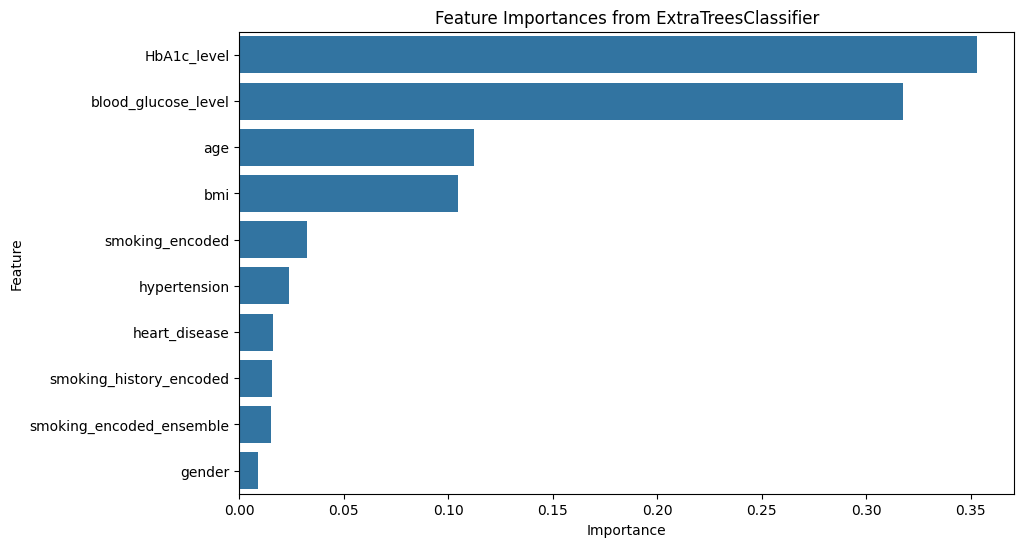

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

# Define Features and Target variables
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Train ExtraTreesClassifier to identify feature importance
model = ExtraTreesClassifier()
model.fit(X, y)
# Get feature importances
importances = model.feature_importances_
# Create a DataFrame for better visualization
feat_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# Sort the DataFrame by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances)
plt.title('Feature Importances from ExtraTreesClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Feature Selection**

In [14]:
# Keep all features for visualization & dashboard interaction
X_full = df.drop(columns=["diabetes"])  # Keeps everything except the target variable

# Optimized feature set (for model training)
selected_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age", "hypertension", "heart_disease", "smoking_encoded"]
X_selected = df[selected_features]

# Target variable remains the same
y = df["diabetes"]


Splitting Data


In [15]:
# We use StratifiedFold so that each fold in x-validation has the same proportion of diabetic and non-diabetic cases as the original dataset. 
# Also ensure balanced class distribution in each fold.
# Also find the best parameters while preventing overfitting
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X_selected, y):
    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]



# 6. Feature Scaling and Normalization

- **Purpose: Feature scaling helps the model converge faster, ensures optimal performance and improves numerical stability.**
- **Method: Standardization (Z-Score Normalization)**

In [16]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'df' is your DataFrame after feature encoding
X = df.drop('diabetes', axis=1)  # 'diabetes' is your target
y = df['diabetes']

# Splitting the dataset into training and testing first
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initializing the scaler
scaler = StandardScaler()

# Fitting scaler on training data only, then transforming both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting scaled data back to DataFrame for better interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Checking the results
X_train_scaled.head()


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_encoded,smoking_history_encoded,smoking_encoded_ensemble
76484,1.180289,0.144164,-0.290873,-0.206441,-0.509643,0.158030,-0.296217,-1.164145,1.489055,-1.455527
31572,-0.845984,0.989825,-0.290873,-0.206441,0.845956,-1.427179,-0.296217,2.173627,0.431681,0.690645
92017,-0.845984,0.144164,-0.290873,-0.206441,0.000927,0.997258,-0.296217,-1.164145,-0.097007,0.378971
31616,1.180289,0.099655,3.437926,-0.206441,0.228833,-0.681198,-1.421004,-1.164145,-0.625694,1.731166
94106,-0.845984,-0.656989,-0.290873,-0.206441,-0.123386,0.904010,1.513222,0.528623,-1.154381,-1.039027


# 7. Model Training

#### **1. Logistic Regression- Model Training**
- **Purpose: Use as a baseline model for predicting diabetes risk.**
- **Outcome: a basic performance benchmark, demonstrates how linear relationships affect diabetes prediction.**

In [17]:
# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Step 1: Perform Train-Test Split (first step always)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Feature scaling using StandardScaler (fit on train, apply to train and test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back into DataFrames for interpretability (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

# Step 3: Train Logistic Regression Model with scaled features
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train_scaled, y_train)

# Step 4: Evaluate and make predictions on test set
y_preds_test_lr = model_lr.predict(X_test_scaled)
store_classification_results("Logistic Regression (scaled)", "test", 0.50, y_test, y_preds_test_lr)

# Step 5: Evaluate and make predictions on train set
y_preds_train_lr = model_lr.predict(X_train_scaled)
store_classification_results("Logistic Regression (scaled)", "train", 0.50, y_train, y_preds_train_lr)

# Model Performance Reports:
print("Model Performance on Test Set with Scaled Features:")
print(classification_report(y_test, y_preds_test_lr))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_preds_test_lr))

print("\nModel Performance on Train Set with Scaled Features:")
print(classification_report(y_train, y_preds_train_lr))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_preds_train_lr))



Results stored successfully: Logistic Regression (scaled) (Threshold: 0.5)
Results stored successfully: Logistic Regression (scaled) (Threshold: 0.5)
Model Performance on Test Set with Scaled Features:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17534
           1       0.87      0.63      0.73      1696

    accuracy                           0.96     19230
   macro avg       0.92      0.81      0.85     19230
weighted avg       0.96      0.96      0.96     19230

Confusion Matrix (Test Set):
[[17370   164]
 [  627  1069]]

Model Performance on Train Set with Scaled Features:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     70130
           1       0.87      0.63      0.73      6786

    accuracy                           0.96     76916
   macro avg       0.92      0.81      0.85     76916
weighted avg       0.96      0.96      0.96     76916

Confusion Matrix (Train Set):


In [19]:
# # Step 2. Use only selected features for model training
# selected_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age", "hypertension", "heart_disease"]
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# # Step 3. Train the model with selected features
# model_lr = LogisticRegression()
# model_lr.fit(X_train_selected, y_train)

# # Step 4: Evaluate and make predictions on test set
# y_preds_test_lr = model_lr.predict(X_test_selected)
# store_classification_results("Logistic Regression", "test", 0.50, y_test, y_preds_test_lr)

# # Step 5: Evaluate and make predictions on train set
# y_preds_train_lr = model_lr.predict(X_train_selected)
# store_classification_results("Logistic Regression", "train", 0.50, y_train, y_preds_train_lr)

# print("Model Performance on Test set with Selected Features:")
# print(classification_report(y_test, y_preds_test_lr))
# print("Confusion Matrix (Test Set):")
# print(confusion_matrix(y_test, y_preds_test_lr))

# print("Model Performance on Train set with Selected Features:")
# print(classification_report(y_train, y_preds_train_lr))
# print("Confusion Matrix (Train Set):")
# print(confusion_matrix(y_train, y_preds_train_lr))


##### **Summary**
    - **Model Accuracy is at 96%**  
    - **When the model predicts diabetes, it is correct 86% of the time**    
    - **However, the model only catches 64% of actual diabetes cases**   
    - **Balanced performance based on f1-score 0.73**   

##### **Concerns**    
    - **We are missing 37% of the actual diabetic cases**   

Check class distribution

diabetes
0    0.91178
1    0.08822
Name: proportion, dtype: float64


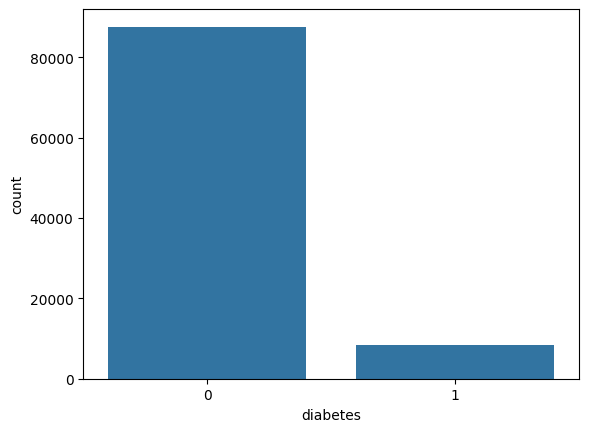

In [18]:
import seaborn as sns

sns.countplot(x=y)
print(y.value_counts(normalize=True))  # Shows class proportions


Handling class imbalance as the Model is predicting majority as 0 meaning "no diabetes"


**Test SMOTE with default threshold 0.50**

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Apply SMOTE to the scaled training set
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Step 2: Train Logistic Regression with balanced, scaled data
model_smote = LogisticRegression(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

# Step 3: Evaluate and make predictions on scaled test set
y_preds_test_smote = model_smote.predict(X_test_scaled)
store_classification_results("Logistic Regression (SMOTE & scaled)", "test", 0.50, y_test, y_preds_test_smote)

# Step 4: Evaluate and make predictions on scaled train set
y_preds_train_smote = model_smote.predict(X_train_scaled)
store_classification_results("Logistic Regression (SMOTE & scaled)", "train", 0.50, y_train, y_preds_train_smote)

# Model Performance Reports:
print("Model Performance on Test Set (SMOTE & Scaled):")
print(classification_report(y_test, y_preds_test_smote))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_preds_test_smote))

print("\nModel Performance on Train Set (SMOTE & Scaled):")
print(classification_report(y_train, y_preds_train_smote))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_preds_train_smote))


Results stored successfully: Logistic Regression (SMOTE & scaled) (Threshold: 0.5)
Results stored successfully: Logistic Regression (SMOTE & scaled) (Threshold: 0.5)
Model Performance on Test Set (SMOTE & Scaled):
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     17534
           1       0.54      0.80      0.65      1696

    accuracy                           0.92     19230
   macro avg       0.76      0.87      0.80     19230
weighted avg       0.94      0.92      0.93     19230

Confusion Matrix (Test Set):
[[16394  1140]
 [  333  1363]]

Model Performance on Train Set (SMOTE & Scaled):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     70130
           1       0.55      0.81      0.66      6786

    accuracy                           0.93     76916
   macro avg       0.77      0.87      0.81     76916
weighted avg       0.94      0.93      0.93     76916

Confusion Matrix (Trai

##### **Summary of Model performance after applying SMOTE**
    **Model Accuracy dropped to 92%**  
    **When the model predicts diabetes, it is correct 53% of the time**    
    **However, the model now catches 80% of actual diabetes cases**   
    **Balanced performance based on f1-score 0.64**   

#####    **We are now only missing 19% of the actual diabetic cases**   

In [21]:
import xgboost
print(xgboost.__version__)  # Should be >= 1.3.0


3.0.0


#### **2. XGBoost- Model Training**
- **Purpose: XGBoost is an advanced gradient boosting alg designed to handle complex interaction and non-linear relationships in structured data.**
- **Outcome: Improved predictive accuracy and robustness compared with simpler models by capturing complex patterns and interactions among features**

[0]	train-logloss:0.67742	eval-logloss:0.67786
[1]	train-logloss:0.64602	eval-logloss:0.64689
[2]	train-logloss:0.61580	eval-logloss:0.61697
[3]	train-logloss:0.58958	eval-logloss:0.59112
[4]	train-logloss:0.56403	eval-logloss:0.56584
[5]	train-logloss:0.54489	eval-logloss:0.54697
[6]	train-logloss:0.52328	eval-logloss:0.52566
[7]	train-logloss:0.50315	eval-logloss:0.50579
[8]	train-logloss:0.48528	eval-logloss:0.48819
[9]	train-logloss:0.47117	eval-logloss:0.47432
[10]	train-logloss:0.45481	eval-logloss:0.45815
[11]	train-logloss:0.44791	eval-logloss:0.45141
[12]	train-logloss:0.44179	eval-logloss:0.44544
[13]	train-logloss:0.43023	eval-logloss:0.43410
[14]	train-logloss:0.41992	eval-logloss:0.42400
[15]	train-logloss:0.41020	eval-logloss:0.41442
[16]	train-logloss:0.39791	eval-logloss:0.40234
[17]	train-logloss:0.38629	eval-logloss:0.39089
[18]	train-logloss:0.37781	eval-logloss:0.38255
[19]	train-logloss:0.36755	eval-logloss:0.37245
[20]	train-logloss:0.36003	eval-logloss:0.36505
[2

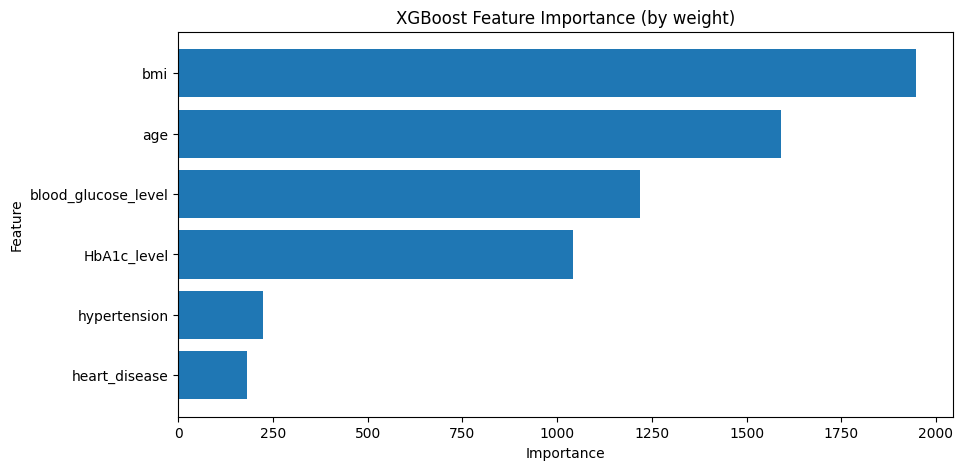

100%|===================| 19151/19230 [02:37<00:00]        

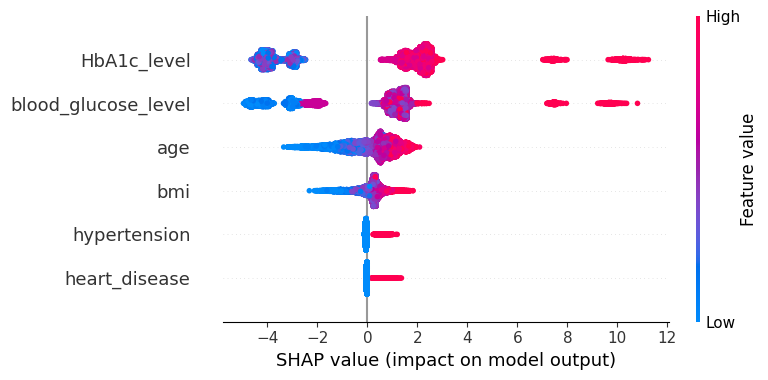


SHAP Feature Importance Ranking:
               Feature  Mean SHAP Value
0          HbA1c_level         2.937688
1  blood_glucose_level         2.249481
3                  age         0.834301
2                  bmi         0.432211
4         hypertension         0.099033
5        heart_disease         0.047363


In [23]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

selected_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age", "hypertension", "heart_disease"]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Scaling explicitly applied
scaler = StandardScaler()
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

# Prepare DMatrix for XGBoost low-level API
# dtrain = xgb.DMatrix(X_train_selected_scaled, label=y_train)
# dtest = xgb.DMatrix(X_test_selected_scaled, label=y_test)
dtrain = xgb.DMatrix(X_train_selected_scaled, label=y_train, feature_names=selected_features)
dtest = xgb.DMatrix(X_test_selected_scaled, label=y_test, feature_names=selected_features)

# Compute class weight ratio
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.05,
    'max_depth': 5,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gamma': 0.1,
    'min_child_weight': 3,
    'seed': 42
}

# Train model with early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=True
)

# Predict test and train
y_preds_test = bst.predict(dtest)
y_preds_test_labels = (y_preds_test >= 0.50).astype(int)

y_preds_train = bst.predict(dtrain)
y_preds_train_labels = (y_preds_train >= 0.50).astype(int)

# Store classification results
store_classification_results("XGBoost (Default threshold 50)", "test", 0.50, y_test, y_preds_test_labels)
store_classification_results("XGBoost (Default threshold 50)", "train", 0.50, y_train, y_preds_train_labels)

# Compute AUC-ROC
roc_auc_test = roc_auc_score(y_test, y_preds_test)
roc_auc_train = roc_auc_score(y_train, y_preds_train)
print(f"Test AUC-ROC: {roc_auc_test:.4f}")
print(f"Train AUC-ROC: {roc_auc_train:.4f}")

# Print classification metrics
print("\nModel Performance on Test set:")
print(classification_report(y_test, y_preds_test_labels))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_preds_test_labels))

print("\nModel Performance on Train set:")
print(classification_report(y_train, y_preds_train_labels))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_preds_train_labels))

# Plot built-in feature importances (from booster)
importance_dict = bst.get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("XGBoost Feature Importance (by weight)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# SHAP Explanation (note: requires passing raw DataFrame, not DMatrix)
# explainer = shap.Explainer(bst, X_test_selected)
# shap_values = explainer(X_test_selected)

# shap.summary_plot(shap_values, X_test_selected)

# ===== SHAP Explanation (Scaled Data) =====
explainer = shap.Explainer(bst, pd.DataFrame(X_test_selected_scaled, columns=selected_features))
shap_values = explainer(pd.DataFrame(X_test_selected_scaled, columns=selected_features))

shap.summary_plot(shap_values, pd.DataFrame(X_test_selected_scaled, columns=selected_features))


# SHAP ranking
shap_importance = pd.DataFrame({
    "Feature": selected_features,
    "Mean SHAP Value": np.abs(shap_values.values).mean(axis=0)
}).sort_values("Mean SHAP Value", ascending=False)

print("\nSHAP Feature Importance Ranking:")
print(shap_importance)


##### **SHAP Summary**
- **Higher HBA1c & blood glucose level indicate higher diabetes risk**
- **low smoking_encoded, hypertension, and heartdisease reduce diabetes risk**

#### **3. Random Forest - Model Training**
- **Purpose: combines multiple decision trees to improve stability, accuracy and reduce overfitting inherent in individual decision trees**
- **Outcome: Improved accuracy and generalization compared to Logistic Regression. Useful for understanding feature importance and interactions**

Feature Engineering Applied: BMI × Age interaction, Age bins added.
Stratified K-Fold ROC AUC Scores: [0.96807593 0.97163311 0.96890035 0.97033352 0.97368115]
Average ROC AUC: 0.9705

RANDOM FOREST - TRAIN SET EVALUATION:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     70130
           1       0.43      0.93      0.59      6786

    accuracy                           0.88     76916
   macro avg       0.71      0.90      0.76     76916
weighted avg       0.94      0.88      0.90     76916

Confusion Matrix:
 [[61642  8488]
 [  469  6317]]
ROC AUC Score: 0.9714
Results stored successfully: Random Forest (Threshold: 0.5)

RANDOM FOREST - TEST SET EVALUATION:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     17534
           1       0.41      0.92      0.57      1696

    accuracy                           0.88     19230
   macro avg       0.70      0.90      0.75     19230
weighted 

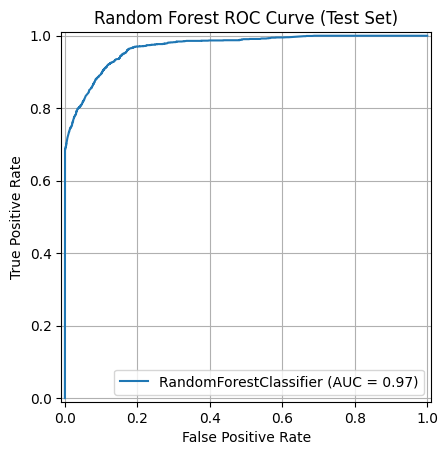

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import matplotlib.pyplot as plt

# ======== APPLY FEATURE ENGINEERING BEFORE CROSS-VALIDATION ========
df_random_forest = df_random_forest.copy()  # Avoid modifying original dataset
df_random_forest["bmi_age_interaction"] = df_random_forest["bmi"] * df_random_forest["age"]
df_random_forest["age_bins"] = pd.cut(df_random_forest["age"], bins=[0, 30, 50, 70, 100], labels=[1, 2, 3, 4]).astype(int)

print("Feature Engineering Applied: BMI × Age interaction, Age bins added.")

# ======== DEFINE FEATURES & TARGET =======
#X = df_random_forest.drop(columns=["diabetes", "bmi_age_interaction"])  # Avoid duplicate interaction feature
X = df_random_forest.drop(columns=["diabetes"])  # Avoid duplicate interaction feature
y = df_random_forest["diabetes"]

# ======== TRAIN-TEST SPLIT ========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ======== STRATIFIED K-FOLD CROSS-VALIDATION (ON TRAINING DATA ONLY) ========
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5,  # Limit tree depth from 8 to 5 to to reduce overfitting
    min_samples_split=10,  # Reduce overfitting
    min_samples_leaf=3,  #added to reduce complexity
    max_leaf_nodes=50,  # Limit number of leaf nodes
    max_features='sqrt', # Use square root of features for each split
    class_weight='balanced', 
    random_state=42
)

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='roc_auc')

print(f'Stratified K-Fold ROC AUC Scores: {cv_scores}')
print(f'Average ROC AUC: {cv_scores.mean():.4f}')

# ======== TRAIN RANDOM FOREST MODEL ========
rf_model.fit(X_train, y_train)

# Predict on train and test
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
y_train_proba_rf = rf_model.predict_proba(X_train)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# ========== TRAIN EVALUATION ==========
print("\nRANDOM FOREST - TRAIN SET EVALUATION:")
print(classification_report(y_train, y_train_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_train, y_train_proba_rf):.4f}")
store_classification_results("Random Forest", "train", 0.50, y_train, y_train_pred_rf)

# ========== TEST EVALUATION ==========
print("\nRANDOM FOREST - TEST SET EVALUATION:")
print(classification_report(y_test, y_test_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_test_proba_rf):.4f}")
store_classification_results("Random Forest", "test", 0.50, y_test, y_test_pred_rf)

# ========== ROC Curve ==========
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("Random Forest ROC Curve (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()


#### **4. Blend XGBoost & Logistic Regression - Model Training - for better performance**
- **Purpose: The blending combines predictions from XGBoost and LR, to leverage strengths of both models for improved accuracy and stability**
- **Outcome: Enhance predictive performance and generatliation by balancing complex relationships captured by XGBoost with linear approach of Logistic Regression**

In [25]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np

# ======= Features and Target =======
selected_features_ensemble = [
    "HbA1c_level", "blood_glucose_level", "bmi", "age",
    "hypertension", "heart_disease", "smoking_encoded_ensemble"
]

X = df_ensemble[selected_features_ensemble]
y = df_ensemble["diabetes"]

# ======= Train-Test Split =======
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ======= Feature Scaling =======
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======= Hyperparameter Tuning for XGBoost =======
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 5],
    'reg_alpha': [0.1],
    'reg_lambda': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.1],
    'min_child_weight': [3],
    'scale_pos_weight': [y_train.value_counts()[0] / y_train.value_counts()[1]],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42, n_estimators=100),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train_scaled, y_train)

print("Best parameters found:", grid_search_xgb.best_params_)
print("Best AUC-ROC score:", grid_search_xgb.best_score_)


# Retrieve the best parameters from GridSearchCV
best_params = grid_search_xgb.best_params_

# Explicitly set parameters for xgb.train
xgb_train_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': best_params['learning_rate'],
    'max_depth': best_params['max_depth'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'min_child_weight': best_params['min_child_weight'],
    'scale_pos_weight': float(best_params['scale_pos_weight']),
    'seed': 42
}

# Convert data into DMatrix format explicitly
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Retrain using xgb.train with early stopping explicitly supported
model_xgboost_optimized = xgb.train(
    params=xgb_train_params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=True
)

# Generate Optimized XGBoost Probabilities explicitly
xgb_train_preds = model_xgboost_optimized.predict(dtrain).reshape(-1, 1)
xgb_test_preds = model_xgboost_optimized.predict(dtest).reshape(-1, 1)




# ======= Train Logistic Regression Meta-Model =======
model_logreg = LogisticRegression(random_state=42)
model_logreg.fit(xgb_train_preds, y_train)

# ======= Final Ensemble Predictions =======
y_preds_train_blend_labels = model_logreg.predict(xgb_train_preds)
y_preds_test_blend_labels = model_logreg.predict(xgb_test_preds)

# ======= Store Results =======
store_classification_results("XGBoost + Logistic Regression (optimized & scaled)", "train", 0.50, y_train, y_preds_train_blend_labels)
store_classification_results("XGBoost + Logistic Regression (optimized & scaled)", "test", 0.50, y_test, y_preds_test_blend_labels)

# ======= Evaluate Final Ensemble Model =======
roc_auc_test = roc_auc_score(y_test, y_preds_test_blend_labels)
roc_auc_train = roc_auc_score(y_train, y_preds_train_blend_labels)
print(f"Test AUC-ROC: {roc_auc_test:.4f}")
print(f"Train AUC-ROC: {roc_auc_train:.4f}")

print("\nBlended Model Performance on Test set:")
print(classification_report(y_test, y_preds_test_blend_labels))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_preds_test_blend_labels))

print("\nBlended Model Performance on Train set:")
print(classification_report(y_train, y_preds_train_blend_labels))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_preds_train_blend_labels))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': np.float64(10.334512231063956), 'subsample': 0.8}
Best AUC-ROC score: 0.9789017935809978
[0]	train-logloss:0.64270	eval-logloss:0.64353
[1]	train-logloss:0.58699	eval-logloss:0.58860
[2]	train-logloss:0.53769	eval-logloss:0.53978
[3]	train-logloss:0.50786	eval-logloss:0.51048
[4]	train-logloss:0.47575	eval-logloss:0.47895
[5]	train-logloss:0.44848	eval-logloss:0.45211
[6]	train-logloss:0.42529	eval-logloss:0.42935
[7]	train-logloss:0.40546	eval-logloss:0.40989
[8]	train-logloss:0.38806	eval-logloss:0.39277
[9]	train-logloss:0.38039	eval-logloss:0.38538
[10]	train-logloss:0.37372	eval-logloss:0.37899
[11]	train-logloss:0.35342	eval-logloss:0.35897
[12]	train-logloss:0.34128	eval-logloss:0.34706
[13]	train-logloss:0.32518	eval-logloss:0.33117
[14]	train

# Save models and scalars

In [26]:
# ======= Save the Ensemble Models and Scaler =======
import joblib

# Save the trained XGBoost booster model
model_xgboost_optimized.save_model("model_xgboost.json")

# Save the trained Logistic Regression model
joblib.dump(model_logreg, "model_logreg.pkl")

# Save the scaler used for preprocessing
joblib.dump(scaler, "scaler.pkl")

print("Models and scaler have been saved successfully.")


Models and scaler have been saved successfully.


**iwith emphasis on balancing bias and variance, we systematically optimized the hyperparameters using GridSearchCV and retrained the XGBoost model explicitly via the native API (xgb.train). This provided a robust solution with explicit early stopping, significantly enhancing model generalization and performance stability.**

# **TESTING**
 - **Include all unit testing below**


In [27]:
df.describe

<bound method NDFrame.describe of        gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0           0  80.0             0              1  25.19          6.6   
1           0  54.0             0              0  27.32          6.6   
2           1  28.0             0              0  27.32          5.7   
3           0  36.0             0              0  23.45          5.0   
4           1  76.0             1              1  20.14          4.8   
...       ...   ...           ...            ...    ...          ...   
96141       0  36.0             0              0  24.60          4.8   
96142       0   2.0             0              0  17.37          6.5   
96143       1  66.0             0              0  27.83          5.7   
96144       0  24.0             0              0  35.42          4.0   
96145       0  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  smoking_encoded  \
0                      140         0        

In [28]:
df.info

<bound method DataFrame.info of        gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0           0  80.0             0              1  25.19          6.6   
1           0  54.0             0              0  27.32          6.6   
2           1  28.0             0              0  27.32          5.7   
3           0  36.0             0              0  23.45          5.0   
4           1  76.0             1              1  20.14          4.8   
...       ...   ...           ...            ...    ...          ...   
96141       0  36.0             0              0  24.60          4.8   
96142       0   2.0             0              0  17.37          6.5   
96143       1  66.0             0              0  27.83          5.7   
96144       0  24.0             0              0  35.42          4.0   
96145       0  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  smoking_encoded  \
0                      140         0         0

In [29]:
import pandas as pd

# Load stored results into a DataFrame
conn = sqlite3.connect("diabetes_results.db")
df_results = pd.read_sql("SELECT * FROM model_results", conn)
conn.close()

# Display results
print(df_results)


   id                                         model_name data_type  threshold  \
0   1                       Logistic Regression (scaled)      test        0.5   
1   2                       Logistic Regression (scaled)     train        0.5   
2   3               Logistic Regression (SMOTE & scaled)      test        0.5   
3   4               Logistic Regression (SMOTE & scaled)     train        0.5   
4   5                     XGBoost (Default threshold 50)      test        0.5   
5   6                     XGBoost (Default threshold 50)     train        0.5   
6   7                                      Random Forest     train        0.5   
7   8                                      Random Forest      test        0.5   
8   9  XGBoost + Logistic Regression (optimized & sca...     train        0.5   
9  10  XGBoost + Logistic Regression (optimized & sca...      test        0.5   

   precision    recall  f1_score  accuracy        run_timestamp  
0   0.866991  0.630307  0.729942  0.958866

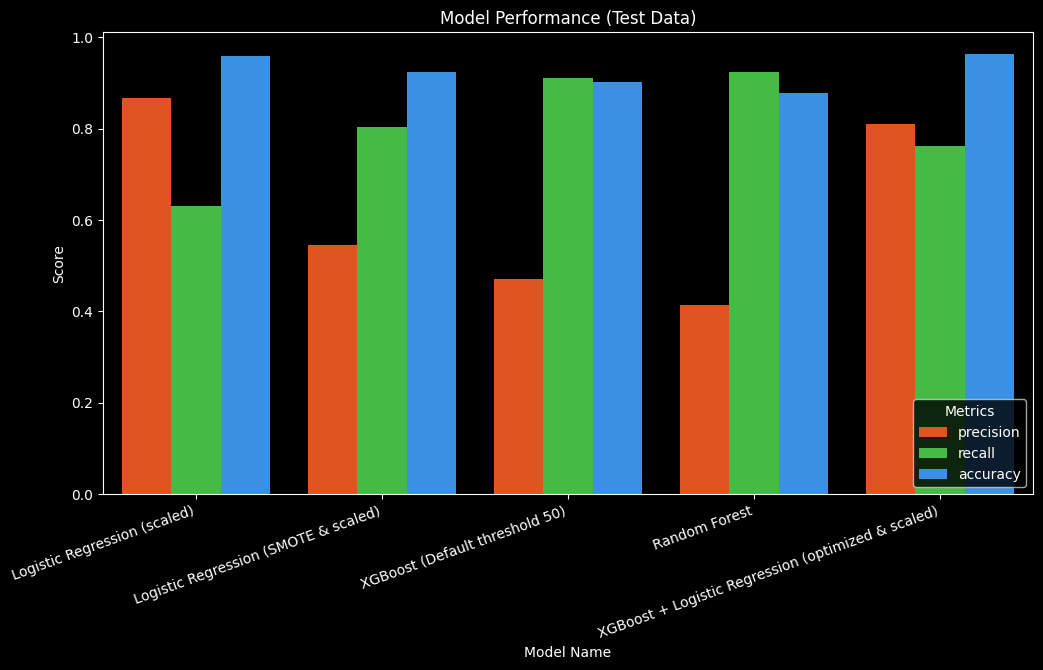

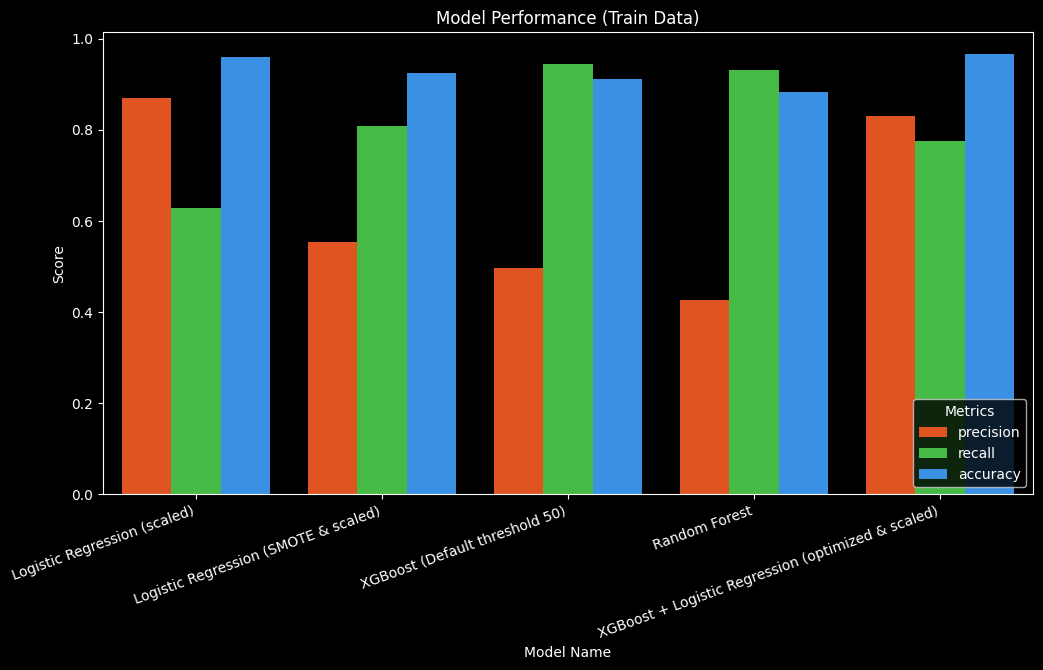

In [30]:
# Re-import necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load stored results into separate DataFrames for test and train
conn = sqlite3.connect("diabetes_results.db")
df_results_test = pd.read_sql("SELECT * FROM model_results WHERE data_type = 'test'", conn)
df_results_train = pd.read_sql("SELECT * FROM model_results WHERE data_type = 'train'", conn)
conn.close()

# Set dark plot style
plt.style.use("dark_background")

# Define brighter colors explicitly
palette = {"precision": "#FF4500", "recall": "#32CD32", "accuracy": "#1E90FF"}

# Function to plot metrics for test and train data separately
def plot_metrics(df, title):
    plt.figure(figsize=(12, 6))
    
    # Reshape DataFrame for seaborn compatibility
    df_melted = df.melt(id_vars='model_name', value_vars=['precision', 'recall', 'accuracy'],
                        var_name='metric', value_name='score')
    
    sns.barplot(data=df_melted, x="model_name", y="score", hue="metric", palette=palette)
    
    # Customize the plot
    plt.xlabel("Model Name")
    plt.ylabel("Score")
    plt.xticks(rotation=20, ha="right")
    plt.title(title)
    plt.legend(title='Metrics', loc='lower right')

    # Show plot
    plt.show()

# Generate separate plots for Test and Train
plot_metrics(df_results_test, "Model Performance (Test Data)")
plot_metrics(df_results_train, "Model Performance (Train Data)")


**Legend**  
    -   **precision: higher the precision, the fewer the false alarms**     
    -   **recall: higher the recall, the model accurately identifies who are diabetic**    

**Line plot for accuracy over Time**

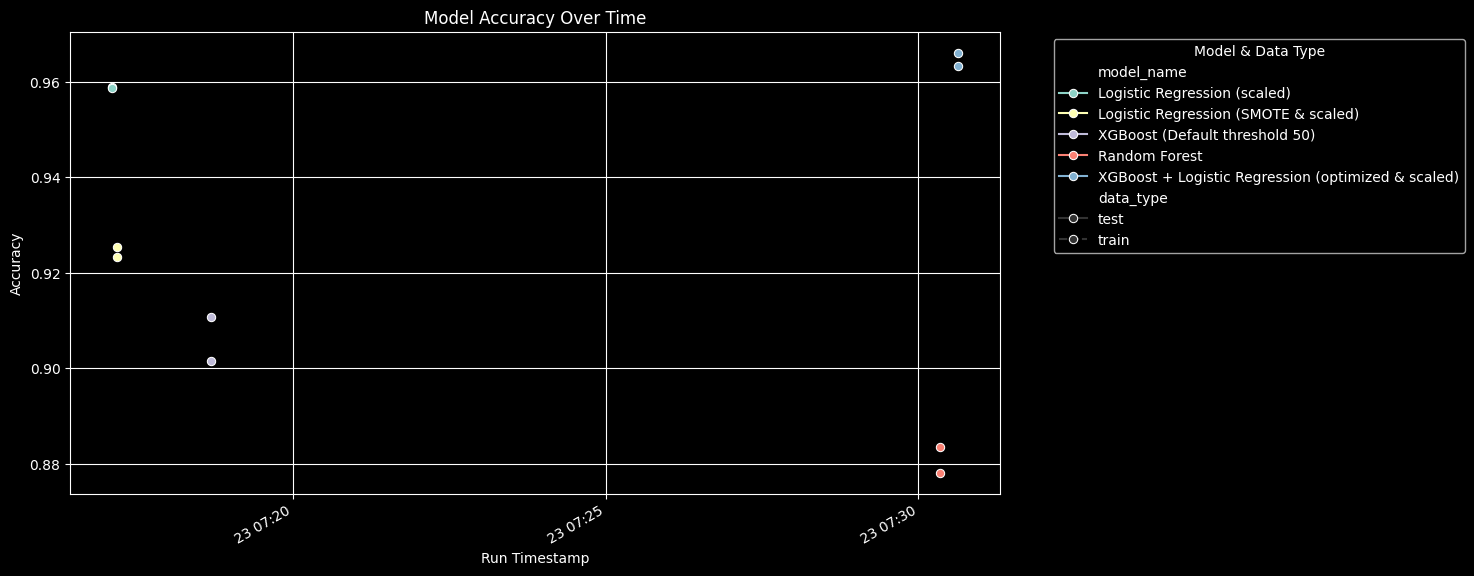

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert timestamp to datetime
df_results['run_timestamp'] = pd.to_datetime(df_results['run_timestamp'])

# Sort by timestamp
df_results = df_results.sort_values(by='run_timestamp')

# Plot accuracy over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_results, x="run_timestamp", y="accuracy", hue="model_name", style="data_type", marker="o")
plt.xticks(rotation=30, ha="right")
plt.xlabel("Run Timestamp")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Time")
plt.legend(title="Model & Data Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()


**Overfitting Analysis**

In [32]:
df_results_pivot = df_results.pivot(index=["model_name", "threshold"], columns="data_type", values="accuracy")
df_results_pivot["overfitting_score"] = df_results_pivot["train"] - df_results_pivot["test"]

# Display models with the highest overfitting scores
df_results_pivot.sort_values(by="overfitting_score", ascending=False)


,data_type,test,train,overfitting_score
model_name,threshold,,,
XGBoost (Default threshold 50),0.5,0.901560,0.910786,0.009226
Random Forest,0.5,0.878107,0.883548,0.005441
XGBoost + Logistic Regression (optimized & scaled),0.5,0.963235,0.966093,0.002858
Logistic Regression (SMOTE & scaled),0.5,0.923401,0.925399,0.001998
Logistic Regression (scaled),0.5,0.958866,0.958825,-0.000041


**Visualize Overfitting Score using Bar Plot**

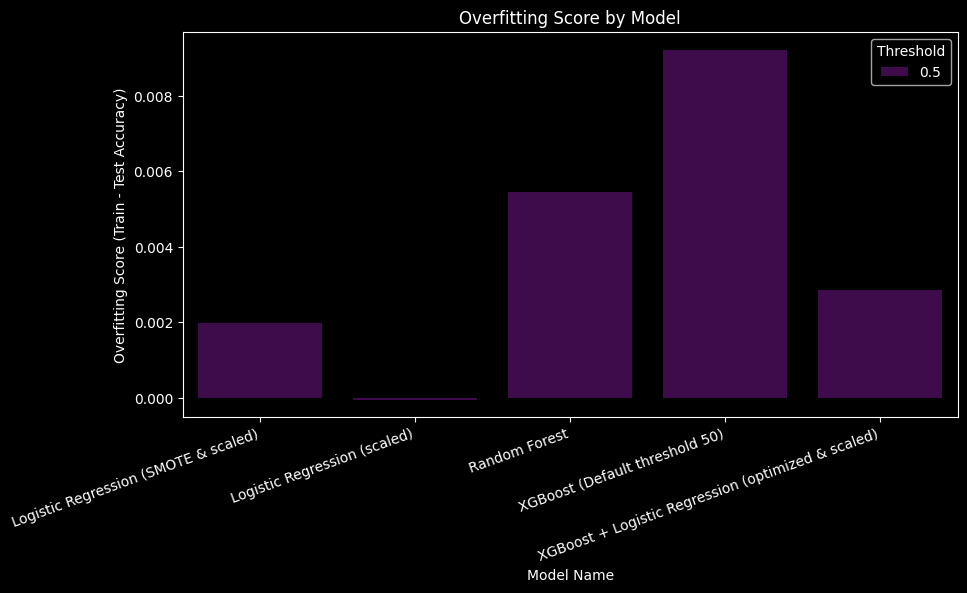

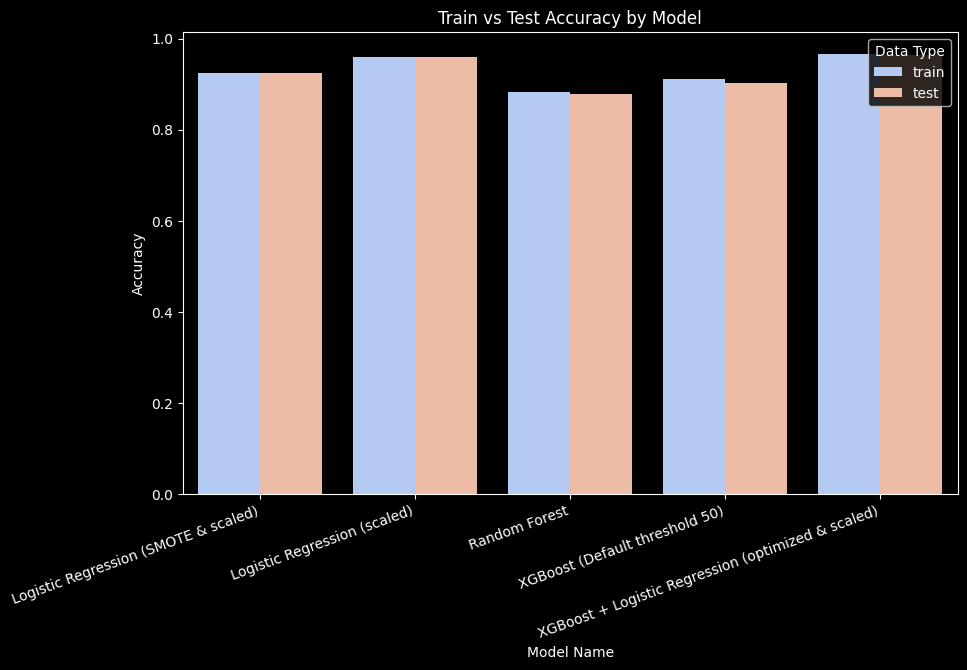

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=df_results_pivot.reset_index(), x="model_name", y="overfitting_score", hue="threshold", palette="viridis")
plt.xlabel("Model Name")
plt.ylabel("Overfitting Score (Train - Test Accuracy)")
plt.title("Overfitting Score by Model")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Threshold")
plt.show()

plt.figure(figsize=(10, 6))
df_melted = df_results_pivot.reset_index().melt(id_vars=["model_name", "threshold"], 
                                                value_vars=["train", "test"],
                                                var_name="data_type", value_name="accuracy")

sns.barplot(data=df_melted, x="model_name", y="accuracy", hue="data_type", palette="coolwarm")
plt.xlabel("Model Name")
plt.ylabel("Accuracy")
plt.xticks(rotation=20, ha="right")
plt.title("Train vs Test Accuracy by Model")
plt.legend(title="Data Type")
plt.show()



**Load saved Models and Run inference on a Sample**

In [34]:
# ======= Test Inference from Saved Models =======
import joblib
import xgboost as xgb
import numpy as np

# Load the saved models and scaler
booster_loaded = xgb.Booster()
booster_loaded.load_model("model_xgboost.json")

logreg_loaded = joblib.load("model_logreg.pkl")
scaler_loaded = joblib.load("scaler.pkl")

# Prepare a test sample (take a row from X_test for validation)
sample_raw = X_test.iloc[0]  # Or replace with new input
sample_scaled = scaler_loaded.transform([sample_raw])  # Keep 2D shape

# Run through XGBoost
dtest_sample = xgb.DMatrix(sample_scaled)
xgb_output = booster_loaded.predict(dtest_sample).reshape(-1, 1)

# Predict final blended output using Logistic Regression
final_proba = logreg_loaded.predict_proba(xgb_output)[0][1]
final_class = logreg_loaded.predict(xgb_output)[0]

# Display Results
print("Raw input features:\n", sample_raw)
print("\nBlended model output:")
print(f" - Predicted class: {int(final_class)}")
print(f" - Diabetes risk score (probability): {final_proba:.4f}")


Raw input features:
 HbA1c_level                   6.600000
blood_glucose_level         159.000000
bmi                          36.770000
age                          51.000000
hypertension                  0.000000
heart_disease                 0.000000
smoking_encoded_ensemble      0.086077
Name: 79323, dtype: float64

Blended model output:
 - Predicted class: 0
 - Diabetes risk score (probability): 0.1241
